<a href="https://colab.research.google.com/github/Sparshj8287/ML_Journey/blob/main/05_transfer_learning_in_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nividia smi


/bin/bash: nividia: command not found


In [ ]:

# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-11-09 12:21:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-09 12:21:23 (76.4 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-11-09 12:21:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip!wget
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-11-09 12:21:25 ERROR 403: Forbidden.

--2022-11-09 12:21:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Reusing existing connection to storage.googleapis.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   219MB/s    in 0.7s    

2022-11-09 12:21:26 (219 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]

FINISHED --2022-11-09 12:21:26--
Total wall clock time: 0.9s
Downloaded: 1 files, 161M 

In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
#Create train and test dataset
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

In [ ]:
#Let's preprocess the data
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", 
                                                                            batch_size=32) 
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
for images,labels in train_data_10_percent.take(1):
  print(images, labels)

In [ ]:
#made data augmentation layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

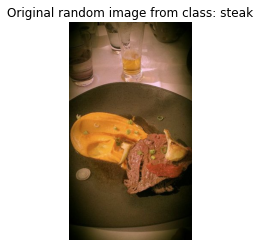

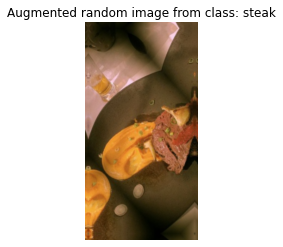

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_10_percent.class_names) # choose a random class
target_dir = "10_food_classes_10_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
#Let's create the first deep learning first functional api
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_10_percent = model_1.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221109-122137
Epoch 1/5
24/24 [==============================] - 24s 582ms/step - loss: 1.9807 - accuracy: 0.3520 - val_loss: 1.4270 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - 11s 442ms/step - loss: 1.2890 - accuracy: 0.7000 - val_loss: 1.0121 - val_accuracy: 0.7730
Epoch 3/5
24/24 [==============================] - 10s 412ms/step - loss: 0.9918 - accuracy: 0.7693 - val_loss: 0.8097 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 10s 404ms/step - loss: 0.8285 - accuracy: 0.8080 - val_loss: 0.6990 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 10s 413ms/step - loss: 0.7221 - accuracy: 0.8267 - val_loss: 0.6547 - val_accuracy: 0.8322


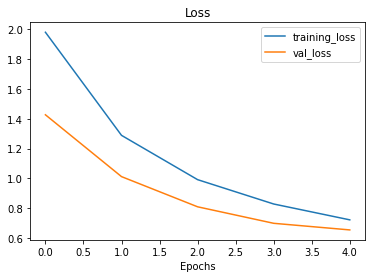

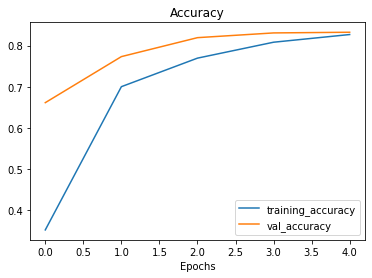

In [ ]:
plot_loss_curves(history_10_percent)

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.6275 - accuracy: 0.8352


[0.6275370121002197, 0.8352000117301941]

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-11-09 12:23:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 142.251.161.128, 74.125.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.3’

10_food_classes_1_p 100%[===================>] 127.42M   170MB/s    in 0.7s    

2022-11-09 12:23:12 (170 MB/s) - ‘10_food_classes_1_percent.zip.3’ saved [133612354/133612354]



In [ ]:
#Let's walk through directory
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

##Gettting and precossing the for model_2

In [ ]:
train_dir_1_percent="10_food_classes_1_percent/train/"
test_data="10_food_classes_1_percent/test/"

In [ ]:
IMG_SHAPE=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SHAPE,
                                                                         batch_size=32)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_data,
                                                              label_mode='categorical',
                                                              image_size=IMG_SHAPE,
                                                              batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

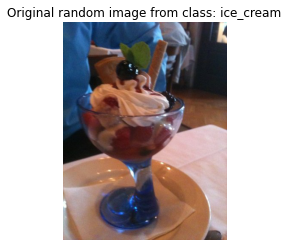

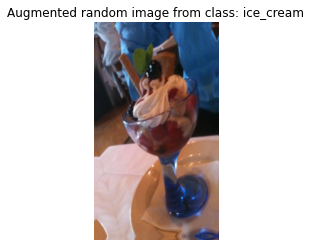

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0),training=True) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Let do another experiment
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221109-142122
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4416 - accuracy: 0.0571 - val_loss: 2.3353 - val_accuracy: 0.1217
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1829 - accuracy: 0.1571 - val_loss: 2.1934 - val_accuracy: 0.1990
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9571 - accuracy: 0.3571 - val_loss: 2.0808 - val_accuracy: 0.2796
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7993 - accuracy: 0.4571 - val_loss: 1.9701 - val_accuracy: 0.3339
Epoch 5/5
3/3 [==============================] - 2s 1s/step - loss: 1.6208 - accuracy: 0.6714 - val_loss: 1.8578 - val_accuracy: 0.4243


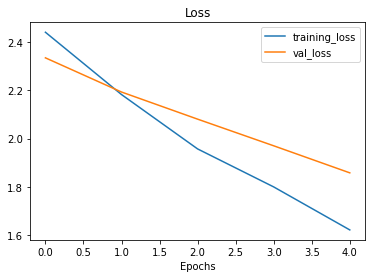

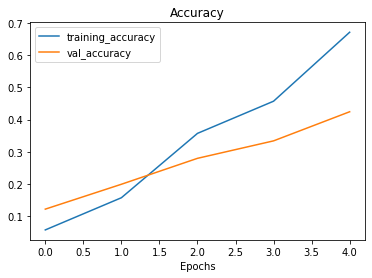

In [ ]:
plot_loss_curves(history_1_percent)

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221109-142155
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0616 - accuracy: 0.3200
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 364ms/step - loss: 2.0616 - accuracy: 0.3200 - val_loss: 1.5026 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3520 - accuracy: 0.6960
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 246ms/step - loss: 1.3520 - accuracy: 0.6960 - val_loss: 1.0135 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0174 - accuracy: 0.7787
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 260ms/step - loss: 1.0174 - accuracy: 0.7787 - val_loss: 0.8203 - val_accuracy: 0.8026
Epo

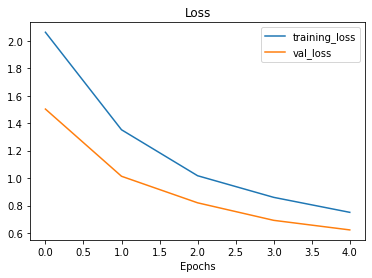

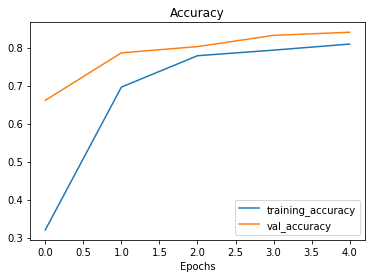

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

#Loading in checkpointed weights

In [ ]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.6423 - accuracy: 0.8384


In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6423 - accuracy: 0.8384


[0.6423221230506897, 0.8384000062942505]

In [ ]:
results_10_percent_data_aug==loaded_weights_model_results

False

In [ ]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
for layer in model_2.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling_layer True
output_layer True


In [ ]:
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer,layer.trainable)

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
print(model_2.trainable_variables)

In [ ]:
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20221109-142303
Epoch 5/10
24/24 [==============================] - 16s 359ms/step - loss: 0.6176 - accuracy: 0.8347 - val_loss: 0.4951 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 7s 267ms/step - loss: 0.4954 - accuracy: 0.8480 - val_loss: 0.4652 - val_accuracy: 0.8520
Epoch 7/10
24/24 [==============================] - 7s 281ms/step - loss: 0.4312 - accuracy: 0.8720 - val_loss: 0.4703 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 7s 263ms/step - loss: 0.3942 - accuracy: 0.8773 - val_loss: 0.4636 - val_accuracy: 0.8503
Epoch 9/10
24/24 [==============================] - 7s 268ms/step - loss: 0.3710 - accuracy: 0.8893 - val_loss: 0.4666 - val_accuracy: 0.8454
Epoch 10/10
24/24 [==============================] - 6s 251ms/step - loss: 0.3218 - accuracy: 0.9067 - val_loss: 0.4445 - val_accuracy: 0.8520


In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4210 - accuracy: 0.8612


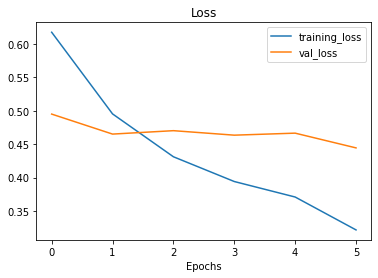

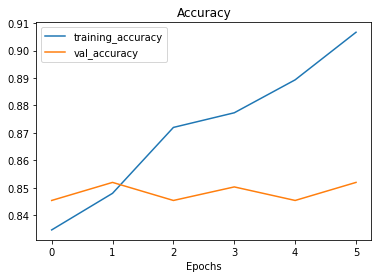

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3199999928474426, 0.6959999799728394, 0.7786666750907898, 0.7933333516120911, 0.809333324432373, 0.8346666693687439, 0.8479999899864197, 0.871999979019165, 0.8773333430290222, 0.8893333077430725, 0.9066666960716248]


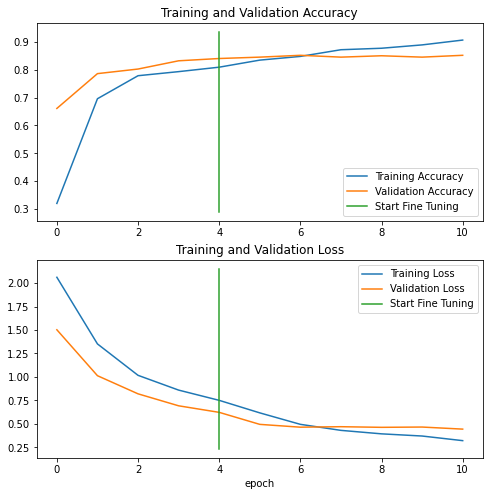

In [ ]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-11-09 14:24:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  88.1MB/s    in 5.2s    

2022-11-09 14:24:12 (95.2 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4210 - accuracy: 0.8612


[0.4210255742073059, 0.8611999750137329]

In [ ]:
results_fine_tune_10_percent

[0.4210255742073059, 0.8611999750137329]

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4210 - accuracy: 0.8612


[0.42102572321891785, 0.8611999750137329]

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4210 - accuracy: 0.8612


[0.4210255444049835, 0.8611999750137329]

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data
                 )

79/79 [==============================] - 7s 77ms/step - loss: 0.6423 - accuracy: 0.8384


[0.642322301864624, 0.8384000062942505]

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20221109-143911
Epoch 5/10
235/235 [==============================] - 51s 189ms/step - loss: 0.6567 - accuracy: 0.7893 - val_loss: 0.3413 - val_accuracy: 0.8947
Epoch 6/10
235/235 [==============================] - 41s 170ms/step - loss: 0.5306 - accuracy: 0.8268 - val_loss: 0.2972 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - 39s 164ms/step - loss: 0.4707 - accuracy: 0.8463 - val_loss: 0.2994 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 39s 162ms/step - loss: 0.4305 - accuracy: 0.8577 - val_loss: 0.2815 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 38s 160ms/step - loss: 0.3897 - accuracy: 0.8744 - val_loss: 0.2470 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 37s 154ms/step - loss: 0.3612 - accuracy: 0.8833 - val_loss: 0.2444 - val_accuracy: 0.9128


In [ ]:
!tensorboard dev list

2022-11-09 14:52:31.295924: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!tensorboard dev delete --experiment_id f0Fre83PTYSMU1HYB7KkSg

2022-11-09 14:54:14.494329: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Deleted experiment f0Fre83PTYSMU1HYB7KkSg.
